# Classificador de notícias

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
from algorithms import utils as ut

#Imports nltk ---------------------------------------------
import nltk
from nltk.stem.snowball import SnowballStemmer

#Imports sklearn ------------------------------------------

#tfidf
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer

# #naive bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB

# #regressão logística
from sklearn.linear_model import LogisticRegression


from algorithms.NearestNeighbors import ClusterNNClassifier, KNNClassifier

### Importando stopwords e stemmer

In [2]:
stemmer = SnowballStemmer('portuguese')
stopwords = nltk.corpus.stopwords.words('portuguese')

### Importando notícias

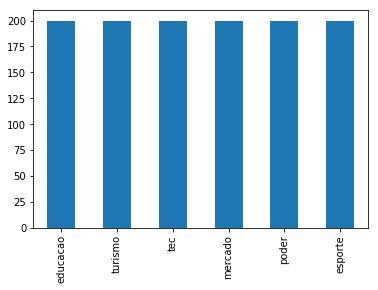

In [3]:
# news,labels = ut.load_xml_news("datasets/news_data.xml", plot=True)
news,labels = ut.load_articles("/Users/lucasperes/notebooks/articles-filtered-200.tsv",plot=True)

## Análise dos atributos das notícias

Através do histograma acima, podemos analizar que todas as notícias possuem data(when), link, imagem e título.

* Imagem e link não são interpretáveis para o nosso problema, logo não compensa que coloquemos estes atributos em nosso classificador;
* Data(when) e data de publicação, embora sejam interpretáveis, é provável que não acrescentem nenhuma informação relevante para nossa classificação;
* Texto, título e descrição podem ser bastante úteis em nosso problema, embora o título, devido a sua natureza mais interativa para chamar a atenção, possa atrapalhar nos cálculos, portanto, colocaremos ele de fora da classificação.

## Iniciando pré-processamento

### Processando notícias

In [4]:
news[0], labels[0]

('Com a possibilidade de uma condenação impedir sua candidatura em 2018, o ex-presidente Luiz Inácio Lula da Silva fez, nesta segunda (9), um discurso inflamado contra a Lava Jato, no qual disse saber que está "lascado", exigiu um pedido de desculpas do juiz Sergio Moro e afirmou que, mesmo fora da disputa pelo Planalto, será um cabo eleitoral expressivo para a sucessão de Michel Temer.  Segundo o petista, réu em sete ações penais, o objetivo de Moro é impedir sua candidatura no ano que vem, desidratando-o, inclusive, no apoio a um nome alternativo, como o do ex-prefeito de São Paulo Fernando Haddad (PT), caso ele não possa concorrer à Presidência.  "Eu sei que tô lascado, todo dia tem um processo. Eu não quero nem que Moro me absolva, eu só quero que ele peça desculpas", disse Lula durante um seminário sobre educação em Brasília. "Eles [investigadores] chegam a dizer: \'Ah, se o Lula não for candidato, ele não vai ter força como cabo eleitoral\'. Testem", completou o petista.  Para o 

In [5]:
#Removendo stopwords,"tokenizando", aplicando stemmer e removendo caracteres indesejáveis
undesired = [',','.',"'",'"','´','`',';',':','-','?','!','%','(',')','\t','\n']
data_processed = []
for k in news:
    tokenizedText = nltk.word_tokenize(k,language='portuguese')
    stemmedText = [stemmer.stem(t) for t in tokenizedText if t not in stopwords and not t in undesired]
    data_processed.append(stemmedText)

In [6]:
#Reescrevendo noticias
new_data = []
for data in data_processed:
    new_data.append(" ".join(data))

data_processed = new_data

data_processed[0],labels[0]

("com possibil conden imped candidatur 2018 ex-president luiz ináci lul silv fez nest segund 9 discurs inflam contr lav jat diss sab `` lasc '' exig ped desculp juiz sergi mor afirm disput planalt cab eleitoral express sucessã michel tem segund petist réu set açõ pen objet mor é imped candidatur ano vem desidratando- inclusiv apoi nom altern ex-prefeit sã paul fern haddad pt cas poss concorr president `` eu sei tô lasc tod dia process eu quer mor absolv quer pec desculp '' diss lul durant seminári sobr educ brasíl `` eles [ investig ] cheg diz 'ah lul candidat vai ter forc cab eleitoral test '' complet petist par ex-president mor usou `` ment cont políc federal ministéri públic '' julgá-l condená-l nov anos seis mes prisã cas tríplex guaruj sp o ex-president diss aind ter `` med '' investig acord acostum `` mex deput senador '' tem apur `` eu quer saib seguint acostum lid deput med mex senador têm med quer diz respeit profund respeit leis ajud cri respeit respeit respeit '' afirm petis

## Iniciando classificação

### Preparando dados para classificação

In [7]:
#Permutação dos dados
temp = np.column_stack((data_processed,labels))
temp = np.random.permutation(temp)
data_processed = temp[:,0]
labels = temp[:,1]

### Gerando matrizes dos dados

In [8]:
cv = CountVectorizer()

X_counts = cv.fit_transform(data_processed)
tf_transformer = TfidfTransformer(use_idf=True).fit(X_counts)
text_tf = tf_transformer.transform(X_counts)

print("Total de tokens: {}".format(text_tf.shape[0]))

Total de tokens: 1200


### Separando features de treino e teste

In [9]:
#Separação das labels de treino e teste
p = 0.8
size = len(data_processed)
partition = math.floor(size*p)

trainLabels = labels[:partition]
trainText = text_tf[:partition]

testText = text_tf[partition:]
testLabels = labels[partition:]

### Classificando

In [10]:
try:
    trainText = trainText.toarray()
    testText = testText.toarray()
    
except Exception:
    pass
    
models = {
    "Gaussian Naive Bayes": GaussianNB(),
    "Multinomial Naive Bayes": MultinomialNB(),
    "Bernoulli Naive Bayes": BernoulliNB(),
    "Nearest Centroid Classifier": ClusterNNClassifier(),
#     "KNN(k=11)": KNNClassifier(k=11),
    "Logistic Regression Classifier(alpha = 0.5)": LogisticRegression(C=.5)
}

for name in models:
    model = models[name]
    model.fit(trainText,trainLabels)
    print("{} score: {}%".format(name,model.score(testText,testLabels)*100))

Gaussian Naive Bayes score: 87.08333333333333%
Multinomial Naive Bayes score: 96.25%
Bernoulli Naive Bayes score: 89.16666666666667%
Nearest Centroid Classifier score: 91.66666666666666%
Logistic Regression Classifier(alpha = 0.5) score: 96.25%


In [11]:
def process_new(new):
    tokenizedText = nltk.word_tokenize(new)
    stemmedText = [stemmer.stem(t) for t in tokenizedText if t not in stopwords]

    text = [word for word in stemmedText if not word in undesired]
    text = " ".join(text)
    cv_text = cv.transform([text])
    
    return tf_transformer.transform(cv_text)

def classify_new(new):
    processed_new = process_new(new).toarray()
    
    for name in models:
        model = models[name]
        y = model.predict(processed_new)
        
        if not type(y) == "str":
            y = y[0]
        
        print("{}: {}".format(name,y))

### Teste com uma notícia

In [12]:
new = "A rodada deste fim de semana ainda não confirmou o título do Corinthians, que segue com mais de 99% de chance de conquista, contra menos de 1% do Atlético Mineiro segundo o site Infobola, do matemático Tristão Garcia. Para o Galo, o triunfo sofre o Figueirense, com um gol no finzinho, além de manter a chance matemática de título para os mineiros, também confirmou o time com uma das vagas para a Libertadores. Para as vagas que restam para a competição sul-americana, o Grêmio, embora derrotado pelo Sport, segue bem tranquilo. Só uma catástrofe tira o time gaúcho da vaga 3 e por isso suas chances estão em 96%. Daí para a frente, a coisa embola um pouco. A rodada fez o leque de possibilidades se ampliar. Um exemplo é que o Flamengo saiu do traço e voltou a ter uma pequena chance após a sua vitória e os resultados dos rivais. Afinal, quem estava bem à frente não venceu. Santos, São Paulo e Internacional seguem bem cotados. O Sport (que tem uma tabela bem complicada e por isso está com apenas 7%) precisa de mais um bom resultado na próxima rodada para se aproximar da trinca. Ponte Preta, Palmeiras, Cruzeiro e o Rubro-Negro (que respira graças ao seu bom número de vitórias que lhe dará vantagem caso empate em pontos contra qualquer um dos demais concorrentes) respiram por aparelho. Na turma que tenta escapar da degola, o Vasco segue construindo notável reação. Embora ainda apareça com 84% de possibilidade de rebaixamento, o Cruz-Maltino conseguiu resultado pouco esperado, a vitória sobre o Palmeiras fora de casa, e pode dar um supersalto rumo à salvação já na próxima rodada quando ocorrem dois jogos de rivais diretos pelo rebaixamento: Goiás x Coritiba e Avaí x Joinville. Olho vivo no Figueirense. A série de resultados ruins fez o time encostar muito no bolo dos desesperados. Já a Chapecoense, com a vitória sobre o Fluminense, se despediu dessa briga."

classify_new(new)

Gaussian Naive Bayes: esporte
Multinomial Naive Bayes: esporte
Bernoulli Naive Bayes: esporte
Nearest Centroid Classifier: e
Logistic Regression Classifier(alpha = 0.5): esporte


### Quem sabe faz ao vivo!

In [13]:
# new = """

# """

# classify_new(new)

### Classificando outro dataset

In [14]:
trained_labels = list(set(trainLabels))
news, labels = ut.load_xml_news("datasets/news_data.xml", plot=False)
labels = np.array(labels)
labels[labels=="economia"] = "mercado"
labels[labels=="política"] = "poder"
labels[labels=="tecnologia"] = "tec"

bool_array = np.array([l in trained_labels for l in labels])

news = list(np.array(news)[bool_array])
news = [process_new(new).toarray() for new in news]

labels = labels[bool_array]

In [15]:
n = len(news)

for name in models:
    model = models[name]
    score = 0
    for new, label in zip(news,labels):
        y = model.predict(new) 
        if not type(y) == "str":
            y = y[0]
        
        if y == label:
            score += 1
    
    print("{}: {}%".format(name,score*100/n))

Gaussian Naive Bayes: 63.945086705202314%
Multinomial Naive Bayes: 85.26011560693641%
Bernoulli Naive Bayes: 70.52023121387283%
Nearest Centroid Classifier: 0.0%
Logistic Regression Classifier(alpha = 0.5): 83.52601156069365%
